In [1]:
import pandas as pd
import numpy as np
from pyteomics import pepxml
from pyteomics import mzml
from pyteomics import mzid
from pyteomics import parser
from pyteomics.mass import unimod
import os
from lxml import etree
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
from Bio import SeqIO
import re
%matplotlib inline

In [2]:
project = '/home/ismael/palaeoproteomics/BLG'
n_procs = 6

# Process software results

We want to extract equivalent PSM information from Mascot, Fragpipe, pFind, MaxQuant, Alphapepet and Metamorpheus.
we will go throigh each run and sample and put the PSM data into a dataframe.
Then we will concatenate the results.

For *de novo* we will do the same, but since it is all done on DeNovoGUI, all the data is already combined.

# Benchmark table

Read and format to use later. It contains software run information

In [5]:
benchmark_table = pd.read_csv(os.path.join(project, 'benchmark_table.csv'), header=0)
benchmark_table

,Search,Engine,Digestion,DB,Pep_length,FDR,System,Run_id,Run settings
0,Open,Fragpipe,Tryptic,DB1,7-25,0.05,Cam HPC,fp_t_db1,Tryptic DB1 7-25
1,Open,Fragpipe,Tryptic,DB2,7-25,0.05,Cam HPC,fp_t_db2,Tryptic DB2 7-25
2,Open,Fragpipe,Semi-tryptic,DB1,7-25,0.05,Cam HPC,fp_st_db1,Semi-tryptic DB1 7-25
3,Open,Fragpipe,Semi-tryptic,DB1,5-25,0.05,Cam HPC,fp_st_5_db1,Semi-tryptic DB1 5-25
4,Open,Fragpipe,Semi-tryptic,DB2,7-25,0.05,Cam HPC,fp_st_db2,Semi-tryptic DB2 7-25
5,Open,Fragpipe,Non-specific,DB1,7-25,0.05,Cam HPC,fp_ns_db1,Non-specific DB1 7-25
6,Open,Fragpipe,Non-specific,DB2,7-25,0.05,Cam HPC,fp_ns_db2,Non-specific DB2 7-25
7,Open,pFind,Tryptic,DB1,7-25,0.05,MiniMax,pf_t_db1,Tryptic DB1 7-25
8,Open,pFind,Tryptic,DB2,7-25,0.05,MiniMax,pf_t_db2,Tryptic DB2 7-25
9,Open,pFind,Semi-tryptic,DB1,7-25,0.05,MiniMax,pf_st_db1,Semi-tryptic DB1 7-25


# BLG and databases

Read database FASTA files and store BLG sequence IDs

Then we will count how many peptides each digestion type produces for each database

In [6]:
fasta_db1_file = os.path.join(project, 'databases/DB1_all_annotated_dairy_BLG_variants_ArchaecRAP3.2_nodups.fasta')
fasta_db2_file = os.path.join(project, 'databases/DB2_Bovinae_Proteome_BLG_variants_ArchaecRAP3.2_nodups.fasta')

fasta_db = {'DB1': SeqIO.to_dict(SeqIO.parse(fasta_db1_file, format='fasta')),
            'DB2': SeqIO.to_dict(SeqIO.parse(fasta_db2_file, format='fasta'))}
fasta_list = {'DB1': list(SeqIO.parse(fasta_db1_file, format='fasta')),
              'DB2': list(SeqIO.parse(fasta_db2_file, format='fasta'))}

decoy_tag = 'rev_'
decoy_tag_metam = 'DECOY_'

# Create a different fasta_db for Metamorpheus
accession_re = re.compile(r'\|(\w+)\|')
fasta_db_metam = {}
for db in fasta_db.keys():
    fasta_db_metam[db] = {}
    fasta_db_metam[db]['P02754'] = fasta_db[db]['sp|P02754A|LACB_BOVIN']
    fasta_db_metam[db][decoy_tag_metam+'P02754'] = fasta_db[db][decoy_tag+'sp|P02754A|LACB_BOVIN']
    for id, seq_rec in fasta_db[db].items():
        acc = accession_re.search(id).group(1)
        if id.startswith(decoy_tag):
            acc = decoy_tag_metam + acc
        fasta_db_metam[db][acc] = seq_rec

In [5]:
print(len(fasta_list['DB1']))
print(len(fasta_list['DB2']))

454
75212


In [7]:
bovin_lacb = {
    'sp|P02754A|LACB_BOVIN', 'P02754A',
    'sp|P02754B|LACB_BOVIN', 'P02754B',
    'sp|P02754C|LACB_BOVIN', 'P02754C',
    'sp|P02754D|LACB_BOVIN', 'P02754D',
    'P02754'
}

other_lacb = {
    'sp|P02755|LACB_BUBBU', 'P02755',
    'sp|P02756|LACB_CAPHI', 'P02756',
    'sp|P02758|LACB1_HORSE', 'P02758',
    'sp|P04119|LACB_PIG', 'P04119',
    'sp|P07380|LACB2_HORSE', 'P07380',
    'sp|P11944|LACB_MACGI', 'P11944',
    'sp|P13613|LACB1_EQUAS', 'P13613',
    'sp|P19647|LACB2_EQUAS', 'P19647',
    'sp|P21664|LACB2_FELCA', 'P21664',
    'sp|P33685|LACB1_CANLF', 'P33685',
    'sp|P33686|LACB2_CANLF', 'P33686',
    'sp|P33687|LACB1_FELCA', 'P33687',
    'sp|P33688|LACB3_FELCA', 'P33688',
    'sp|P67975|LACB_OVIMU', 'P67975',
    'sp|P67976|LACB_SHEEP', 'P67976',
    'sp|Q29614|LACB_MACEU', 'Q29614'
}


### Count peptides

In [6]:
parser.expasy_rules

{'arg-c': 'R',
 'asp-n': '\\w(?=D)',
 'bnps-skatole': 'W',
 'caspase 1': '(?<=[FWYL]\\w[HAT])D(?=[^PEDQKR])',
 'caspase 2': '(?<=DVA)D(?=[^PEDQKR])',
 'caspase 3': '(?<=DMQ)D(?=[^PEDQKR])',
 'caspase 4': '(?<=LEV)D(?=[^PEDQKR])',
 'caspase 5': '(?<=[LW]EH)D',
 'caspase 6': '(?<=VE[HI])D(?=[^PEDQKR])',
 'caspase 7': '(?<=DEV)D(?=[^PEDQKR])',
 'caspase 8': '(?<=[IL]ET)D(?=[^PEDQKR])',
 'caspase 9': '(?<=LEH)D',
 'caspase 10': '(?<=IEA)D',
 'chymotrypsin high specificity': '([FY](?=[^P]))|(W(?=[^MP]))',
 'chymotrypsin low specificity': '([FLY](?=[^P]))|(W(?=[^MP]))|(M(?=[^PY]))|(H(?=[^DMPW]))',
 'clostripain': 'R',
 'cnbr': 'M',
 'enterokinase': '(?<=[DE]{3})K',
 'factor xa': '(?<=[AFGILTVM][DE]G)R',
 'formic acid': 'D',
 'glutamyl endopeptidase': 'E',
 'granzyme b': '(?<=IEP)D',
 'hydroxylamine': 'N(?=G)',
 'iodosobenzoic acid': 'W',
 'lysc': 'K',
 'ntcb': '\\w(?=C)',
 'pepsin ph1.3': '((?<=[^HKR][^P])[^R](?=[FL][^P]))|((?<=[^HKR][^P])[FL](?=\\w[^P]))',
 'pepsin ph2.0': '((?<=[^HKR][^P])

In [17]:
# Enzyte, semispecific or not, and # of missed cleavages
# For unspecific, # missed cleavages is equal to max pep length
digestion = {'tryptic': ['trypsin', False, 2],
            'semi_trypsin': ['trypsin', True, 2],
             'non_specific': ['', True, 25]}
dbs = ['DB1', 'DB2']

for db in dbs:
    for dig_type, rules in digestion.items():
        n_peptides = 0
        for seq_record in fasta_list[db]:
            if seq_record.id.startswith(decoy_tag):
                continue
            digested = parser.cleave(
                str(seq_record.seq),
                rule = parser.expasy_rules.get(rules[0], ''),
                semi = rules[1],
                missed_cleavages = rules[2],
                min_length = 7, max_length = 25)
            n_peptides += len(digested)
        print(f'{db} {dig_type}: {n_peptides}')
        

DB1 tryptic: 9302
DB1 semi_trypsin: 102127
DB1 non_specific: 1092998
DB2 tryptic: 3640393
DB2 semi_trypsin: 38385707
DB2 non_specific: 415906748


# Read mzML spectra files

In [8]:
folder = '/home/ismael/palaeoproteomics/BLG/mzml_files'
mzml_paths = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.mzML')]
samples = [os.path.basename(f).rstrip('.mzML') for f in mzml_paths]
print(samples)
print(mzml_paths)

['N1280', 'N0040', 'N0000']

In [10]:
def count_spectra(paths):
    # This function counts MS1 and MS2 spectra
    scan_counts = []
    for p in paths:
        file = os.path.basename(p)
        sample = file.rstrip('.mzML')
        tree = etree.parse(p)
        root = tree.getroot()
        ms1spectra =  root.xpath(
            "mzml:mzML/mzml:run/mzml:spectrumList/mzml:spectrum"
            "[mzml:cvParam/@name='ms level' and mzml:cvParam/@value='1']",
            namespaces={'mzml':'http://psi.hupo.org/ms/mzml'})
        ms2spectra =  root.xpath(
            "mzml:mzML/mzml:run/mzml:spectrumList/mzml:spectrum"
            "[mzml:cvParam/@name='ms level' and mzml:cvParam/@value='2']",
            namespaces={'mzml':'http://psi.hupo.org/ms/mzml'})
        scan_counts.append([sample, len(ms1spectra), len(ms2spectra)])
    n_scans = pd.DataFrame(scan_counts, columns=['Sample', 'n_ms1scans', 'n_ms2scans'])
    return n_scans

In [11]:
if os.path.exists(os.path.join(project,'analysis_results/n_scans_samples.csv')):
    n_scans = pd.read_csv(os.path.join(project,'analysis_results/n_scans_samples.csv'))
else:
    n_scans = count_spectra(mzml_paths)
    n_scans.to_csv(os.path.join(project,'analysis_results/n_scans_samples.csv'), index=False)

In [ ]:
# Some software don't report RT in their output, 
# so we keep the spectra to query for each spectrum retention time
spectra_dict = {}
for p in mzml_paths:
    file = os.path.basename(p)
    sample = file.rstrip('.mzML')
    mzml_spectra = mzml.read(p, use_index=True)
    spectra_dict[sample] = mzml_spectra

SCAN INDEX IS 0-BASED AND GOES WITH ARRAY INDEX
SCAN NUMBER AND SPECTRUM TITLE/NAME ARE 1-BASED

# PTMs
Load Unimod database

In [ ]:
unimod_db = unimod.Unimod()

In [ ]:
unknown_mods = {'C+12'}
map_mods = {'DiDehydro': 'Didehydro',
            'Bodipy': 'ZGB'}
add_colon = ('Cation', 'Xlink', 'Unknown', 'Biotin_Thermo')

## Functions and globals
Define some common functions to read PSMs data from different software and formats:
- `get_prot_info`
    We will always reference BLG position wrt to bovinBLG if present among identified proteins
- `get_rt`

Define some global variables

In [ ]:
def get_prot_info(pept_seq, proteins, bovin_lacb, other_lacb, fdb, field='protein'):
    """
    Return the start and end of a peptide sequence within a protein, using a list of identified proteins
    If present, it preferentially uses a bovin LACB to get the start and end. Otherwise any other LACB
    If none are present, it will use the first protein in the list
    It needs a dictionary of protein ID keys to Bio.SeqRecord objects
    :param pept_seq: Peptide sequence
    :param proteins: List of strings or dicts. Strings are protein IDs, if dicts they contain protein ID in field
    :param bovin_lacb: List of bovin LACB IDs
    :param other_lacb: List of other LACBs
    :param fdb: Dictionary of Bio.SeqRecords as returned by SeqIO.to_dict
    :param field: f proteins is list of dicts, name of field that contains the ID
    :return: protein id, start and end (0-based)
    """

    # See if peptide matches to any LACB
    prot_id = proteins[0][field] if field != '' else proteins[0]
    for p in proteins:
        p = p[field] if field != '' else p
        if p in bovin_lacb:
            prot_id = p
            break
        if p in other_lacb:
            prot_id = p
    # Get protein sequence using prot_id and get peptide start and end
    seq_rec = fdb.get(prot_id, None)
    if seq_rec is None:
        return '', -1, -1
    prot_seq = seq_rec.seq
    pstart = prot_seq.find(pept_seq)
    pend = pstart + len(pept_seq) - 1
    return prot_id, pstart, pend


def get_rt(scan_ns, mzml_spectra):
    """
    Given a list of scan numbers, it retrieves the RT from mzML pyteomics object
    :param scan_ns: List of scan numbers
    :param mzml_spectra: mzML object
    :return: DataFrame with columns scan index and RTsec
    """
    scan_idx = scan_ns - 1
    sel_mzml = mzml_spectra[scan_idx.tolist()]
    rt_list = []
    for i in range(len(scan_idx)):
        rt = sel_mzml[i]['scanList']['scan'][0]['scan start time'] * 60
        rt_list.append([scan_idx[i], rt])
    return pd.DataFrame(rt_list, columns=['Scan_idx', 'RTsec'])


This is a PepXML data extractor that works for Mascot and Fragpipe pepXML flavours

In [ ]:
class PepXMLdataEctractor:
    """
    Extracts data from pyteomics pepxml object. The object is callable and can be passed to
    the pepxml map method to extractdata from PSMs.
    It works with Mascot and FragPipe pepxml flavours
    """
    def __init__(self, flavour):
        self.empty_pept_seq = ''
        self.empty_prot_id = ''
        self.empty_pstart = -1
        self.empty_pend = -1
        self.empty_isdecoy = None
        self.empty_delta_mass = np.nan
        self.empty_calc_mass = np.nan
        self.empty_qval_key = np.nan
        self.empty_scan_no = -1
        self.empty_rt = np.nan
        if flavour == 'mascot':
            self.qval_key_f = self.mascot_expectation
            self.scan_no_f = self.mascot_scan_no
            self.rt_f = self.mascot_rt
        elif flavour == 'fragpipe':
            self.qval_key_f = self.fragpipe_probability
            self.scan_no_f = self.fragpipe_scan_no
            self.rt_f = self.fragpipe_rt


    def empty_sample(self):
        psm_data = [self.empty_scan_no, self.empty_rt, self.empty_pept_seq,
                    self.empty_prot_id, self.empty_pstart, self.empty_pend,
                    self.empty_isdecoy,  self.empty_calc_mass, self.empty_delta_mass,
                    self.empty_qval_key]
        return psm_data

    @staticmethod
    def mascot_expectation(psm):
        return psm['search_hit'][0]['search_score']['expect']

    @staticmethod
    def mascot_scan_no(psm):
        return int(psm['spectrum'].split(' ')[2].split('=')[1])

    @staticmethod
    def mascot_rt(psm):
        return float(psm['search_specification'].split(' ')[2].split('(')[1].rstrip(')'))

    @staticmethod
    def fragpipe_probability(psm):
        return psm['search_hit'][0]['analysis_result'][0]['peptideprophet_result']['probability']

    @staticmethod
    def fragpipe_scan_no(psm):
        return psm['start_scan']

    @staticmethod
    def fragpipe_rt(psm):
        return psm['retention_time_sec']

    def get_pepxml_data(self, psm, bovin_lacb, other_lacb, fdb):
        rt = self.rt_f(psm)
        scan_no = self.scan_no_f(psm)
        if 'search_hit' not in psm:
            psm_data = [scan_no, rt, self.empty_pept_seq,
                        self.empty_prot_id, self.empty_pstart, self.empty_pend,
                        self.empty_isdecoy,  self.empty_calc_mass, self.empty_delta_mass,
                        self.empty_qval_key]
        else:
            pept_seq = psm['search_hit'][0]['peptide']
            prot_id, pstart, pend = get_prot_info(
                pept_seq, psm['search_hit'][0]['proteins'],
                bovin_lacb, other_lacb, fdb, field='protein')
            isdecoy = pepxml.is_decoy(psm, prefix=decoy_tag)
            delta_mass = psm['search_hit'][0]['massdiff']
            calc_mass = psm['search_hit'][0]['calc_neutral_pep_mass']
            qval_key = self.qval_key_f(psm)
            psm_data = [
                scan_no, rt, pept_seq,
                prot_id, pstart, pend,
                isdecoy, calc_mass, delta_mass,
                qval_key]
        return psm_data

    def __call__(self, *args, **kwargs):
        return self.get_pepxml_data(*args, **kwargs)


In [14]:
# Thresholds of q_values to count PSMs
q_val_thresholds = np.arange(0.05, 0, -0.00001)

Run time tests on how to extract scan number and RT from scan titles and data. It could be using split or with regular expressions

In [ ]:
# Test functions
run_timeit = False

if run_timeit:
    import re
    import timeit

    string_scan = 'controllerType=0 controllerNumber=1 scan=6905'
    string_rt = 'intensity(3084326.2031) scans(7290) rtinseconds(1417.79)'
    scan_regex = re.compile(r'scan=(\d+)')
    rt_regex = re.compile(r'rtinseconds\(([\d.]+)\)')

    def with_regex(scan, rt):
        return (scan_regex.search(scan).group(1),
                rt_regex.search(rt).group(1))

    def with_split(scan, rt):
        return (scan.split(' ')[2].split('=')[1],
                rt.split(' ')[2].split('(')[1].rstrip(')'))

    def mixed1(scan, rt):
        return (scan.split(' ')[2].split('=')[1],
                 rt_regex.search(rt).group(1))

    def mixed2(scan, rt):
        return (scan_regex.search(scan).group(1),
                rt.split(' ')[2].split('(')[1].rstrip(')'))

    regex_times = (
        timeit.Timer(lambda: with_regex(string_scan, string_rt))
        .repeat(number=10**5, repeat=20))

    split_times = (
        timeit.Timer(lambda: with_split(string_scan, string_rt))
        .repeat(number=10**5, repeat=20))

    mixed1_times = (
        timeit.Timer(lambda: mixed1(string_scan, string_rt))
        .repeat(number=10**5, repeat=20))

    mixed2_times = (
        timeit.Timer(lambda: mixed2(string_scan, string_rt))
        .repeat(number=10**5, repeat=20))



    for i in range(len(regex_times)):
        print(regex_times[i], split_times[i], mixed1_times[i], mixed2_times[i])
    print(f'Means:\n'
          f'Using regex: {np.mean(regex_times):.3f}\n'
          f'Using split: {np.mean(split_times):.3f}\n'
          f'Scan with split, RT with regex {np.mean(mixed1_times):.3f}\n'
          f'Scan with regex, RT with split {np.mean(mixed2_times):.3f}')


Using split is faster

# Mascot

MASCOT provides a pepxml. But some of the data we need is not directly provided:
  - Scan number and RT is extracted from the spectrum title search specification.
  - Peptide position is not directly provided, so we search the peptide in the protein sequence and get the position using `get_prot_info`
  - We determine if the protein is LACB and if in particular is bovin LACB using `get_prot_info`
  - We need to use pyteomics `is_decoy` function to determine if the match is a decoy peptide
  - q-values are calculated using the expectation, refined by percolator

In [ ]:
mascot_runs = [
    'mascot_ns_db1', 'mascot_ns_db2',
    'mascot_st_db1', 'mascot_st_db2',
    'mascot_t_db1', 'mascot_t_db2']

mascot_results_folder = os.path.join(project,'benchmark_results/mascot/filtered')
mascot_pepxml_target = PepXMLdataEctractor(flavour='mascot')


In [ ]:
mascot_psm_data = []

for mascot in mascot_runs:
    print(f'Collecting run {mascot}')
    # Ger run DB
    dbn = benchmark_table.loc[benchmark_table['Run_id'] == mascot, 'DB'].values[0]
    fdb = fasta_db[dbn]
    for s in samples:
        print(f'\tSample {s} ... ', end='')
        pepxml_file = os.path.join(
            mascot_results_folder,  f'{mascot}_{s}_filtered.pepxml'
        )

        pepxml_data = pepxml.PepXML(pepxml_file)
        psm_data = pepxml_data.map(
            mascot_pepxml_target, processes=n_procs,
            bovin_lacb=bovin_lacb, other_lacb=other_lacb,
            fdb=fdb)
        psm_data = pd.DataFrame(psm_data)
        psm_data.columns = [
            'Scan_No', 'RTsec', 'Seq',
            'prot_id','start', 'end',
            'is_decoy', 'calc_mass', 'delta_mass',
            'expectation'
        ]

        psm_data = pepxml.qvalues(
            psm_data, key='expectation', reverse=False, correction=0,
            is_decoy='is_decoy', full_output=True)

        psm_data['Run_id'] = mascot
        psm_data['Sample'] = s
        mascot_psm_data.append(psm_data)
        print('Done')

mascot_psm_data = pd.concat(mascot_psm_data)
mascot_psm_data = mascot_psm_data.drop('expectation', axis='columns')
mascot_psm_data['Scan_idx'] = mascot_psm_data['Scan_No'] - 1


# Fragpipe

Fragpipe provides a pepxml.
We are reading the interact.pep.xml from each sample. It contains PSMs after Crystal-C and PeptidePrphet

Things to consider:
- Position of peptide in protein is 1-based in psm.tsv, but we will do the search 0-based with `get_pept_pos`
- Delta mass is observed - calculated
- q-values are calculated using peptide_prophet probability

In [ ]:
# frag_runs = [
#     'fp_ns_db1', 'fp_ns_db2',
#     'fp_st_5_db1', 'fp_st_db1', 'fp_st_db2',
#     'fp_t_db1', 'fp_t_db2']

frag_runs = [
    'fp_ns_db1', 'fp_ns_db2',
    'fp_st_db1', 'fp_st_db2',
    'fp_t_db1', 'fp_t_db2']
ptm_shepher_folder = 'ptm-shepherd-output'
frag_results_folder = os.path.join(project,'benchmark_results/fragpipe')
fragpipe_pepxml_target = PepXMLdataEctractor(flavour='fragpipe')

In [ ]:
frag_psm_data = []
for fp in frag_runs:
    print(f'Collecting run {fp}')
    fp_path = os.path.join(frag_results_folder, fp)
    # Get run db
    dbn = benchmark_table.loc[benchmark_table['Run_id'] == fp, 'DB'].values[0]
    fdb = fasta_db[dbn]
    exp_folders = [
        f for f in os.listdir(fp_path)
        if f != ptm_shepher_folder and os.path.isdir(os.path.join(fp_path, f))]
    for exp in exp_folders:
        print(f'\tSample {exp} ... ', end='')
        exp_path = os.path.join(fp_path, exp)
        pepxml_file = os.path.join(exp_path, 'interact.pep.xml')
        pepxml_data = pepxml.PepXML(pepxml_file)
        if len(pepxml_data) == 0:
            psm_data = [fragpipe_pepxml_target.empty_sample()]
        else:
            psm_data = pepxml_data.map(
                fragpipe_pepxml_target, processes=n_procs,
                bovin_lacb=bovin_lacb, other_lacb=other_lacb,
                fdb=fdb)
        psm_data = pd.DataFrame(psm_data)
        psm_data.columns = [
            'Scan_No', 'RTsec', 'Seq',
            'prot_id','start', 'end',
            'is_decoy', 'calc_mass', 'delta_mass',
            'probability'
        ]
        psm_data['Run_id'] = fp
        psm_data['Sample'] = exp
        psm_data = pepxml.qvalues(
            psm_data, key='probability', reverse=True, correction=0,
            is_decoy='is_decoy', full_output=True)
        frag_psm_data.append(psm_data)
        print('Done')

frag_psm_data = pd.concat(frag_psm_data)

# frag_psm_data.columns = ['Run_id', 'Sample', 'Scan_No', 'Seq', 'RTsec', 'start', 'end']
frag_psm_data = frag_psm_data.drop('probability', axis='columns')
frag_psm_data['Scan_idx'] = frag_psm_data['Scan_No'] - 1


# pFind

pFind provides a DataFrame with a PSM per row.

- In pFind position of peptide in protein is 0-based
- Several PSMs per spectra. We need to pick the best scoring
- q-value is already given
- Delta mass is observed - calculated. But we need to recalculate it from the Modifications it finds

In [ ]:
pfind_runs = ['pf_ns_db1', 'pf_ns_db2', 'pf_st_db1', 'pf_st_db2', 'pf_t_db1', 'pf_t_db2']
pfind_results_folder = os.path.join(project,'benchmark_results/pFind')


In [ ]:
def get_ptms_mass(ptms, unimod_db):
    ## Take masses from all PTMs from unimod and calculate the delta mass
    ptms_mass = 0
    for p in ptms[:-1]:
        ptm_name = (
            p
            .split('(')[0]
            .split(',')[1].split('[')[:-1])
        ptm_name = '['.join(ptm_name)
        ptm_name = map_mods.get(ptm_name, ptm_name)
        if ptm_name.startswith(add_colon):
            ptm_name = ptm_name.replace('_', ':')
        if ptm_name in unknown_mods:
            return np.nan
        ptms_mass += unimod_db.get(ptm_name, strict=True).monoisotopic_mass
    return ptms_mass

In [ ]:
pfind_psm_data = []
for pf in pfind_runs:
    print(f'Collecting run {pf} ... ')

    dbn = benchmark_table.loc[benchmark_table['Run_id'] == pf, 'DB'].values[0]
    fdb = fasta_db[dbn]

    pfdf = pd.read_csv(
        os.path.join(pfind_results_folder, pf, 'pFind-Filtered.spectra'), sep='\t')
    pfdf = pfdf.astype({'File_Name': pd.StringDtype()})
    pfdf['Sample'] = pfdf['File_Name'].str.split('.').str[0]
    # Pick best PSM per scan
    pfdf_filt = (
        pfdf.groupby(['Sample', 'Scan_No'], as_index=False)
        .apply(lambda x: x.iloc[np.argmin(x['Final_Score']),:]))

    # Get protein ID and start and end
    pfdf_filt[['prot_id', 'start', 'end']] = (
        pfdf_filt[['Sequence', 'Proteins']]
        .apply(lambda x: get_prot_info(x['Sequence'], x['Proteins'].split('/'),
                                       bovin_lacb, other_lacb, fdb, field=''),
               axis=1, result_type='expand'))

    # Change NaN modifications to '' (empty string)
    pfdf_filt.loc[pfdf_filt['Modification'].isnull(), 'Modification'] = ''

    pfdf_filt['delta_mass'] = (
        pfdf_filt['Modification']
        .str.split(';')
        .apply(lambda x: get_ptms_mass(x, unimod_db)))

    pfdf_filt['Calc.MH+'] = pfdf_filt['Calc.MH+'] - pfdf_filt['delta_mass']
    pfdf_filt['delta_mass'] = pfdf_filt['delta_mass'] + pfdf_filt['Mass_Shift(Exp.-Calc.)']

    pfdf_filt = pfdf_filt[[
        'Sample', 'Sequence', 'Scan_No', 'start', 'end', 'Q-value', 'prot_id',
        'Calc.MH+', 'delta_mass']]

    rt = pfdf_filt.groupby('Sample', as_index=False)[['Sample', 'Scan_No']].apply(
        lambda x: get_rt(x['Scan_No'].to_numpy(), spectra_dict[x.iloc[0,0]]))

    pfdf_filt = pd.concat([pfdf_filt, rt.reset_index(drop=True)], axis=1)
    pfdf_filt['Run_id'] = pf

    pfind_psm_data.append(pfdf_filt)

    print('Done')


pfind_psm_data = pd.concat(pfind_psm_data)

pfind_psm_data = pfind_psm_data.rename(columns={
    'Sequence': 'Seq',
    'Q-value': 'q',
    'Calc.MH+': 'calc_mass'
})

pfind_psm_data['Scan_idx'] = pfind_psm_data['Scan_No'] - 1
pfind_psm_data['is_decoy'] = False
# pfind_psm_data.columns = ['Sample', 'Seq', 'Scan_No', 'start', 'end', 'q', 'is_lacb', 'Scan_idx', 'RTsec', 'Run_id']


# MaxQaunt

We read the text tsv files.
MaxQuant gives peptide position in the protein.
However, we will recalculate it with respect to the bovin BLG (when it is among the matched proteins)

In [ ]:
mq_runs = ['mq_ns_db1', 'mq_ns_db2', 'mq_st_db1', 'mq_st_db2', 'mq_t_db1', 'mq_t_db2']

mq_results_folder = os.path.join(project,'benchmark_results/maxquant')

In [ ]:
mq_psm_data = []

for mq in mq_runs:
    print(f'Collecting run {mq} ... ', end='')

    dbn = benchmark_table.loc[benchmark_table['Run_id'] == mq, 'DB'].values[0]
    fdb = fasta_db[dbn]

    mq_scans = pd.read_csv(os.path.join(mq_results_folder, mq, 'txt/msmsScans.txt'), sep='\t')
    mq_msms = pd.read_csv(os.path.join(mq_results_folder, mq, 'txt/msms.txt'), sep='\t')
    mq_msms = mq_msms[['id', 'Peptide ID', 'Mass error [Da]']]
    mq_peps = pd.read_csv(os.path.join(mq_results_folder, mq, 'txt/peptides.txt'), sep='\t')
    mq_peps = mq_peps[['Start position', 'End position', 'id']]
    # Change reverse column, to True or False

    mq_scans.loc[mq_scans['Reverse'] == '+', 'Reverse'] = True
    mq_scans.loc[mq_scans['Reverse'].isna(), 'Reverse'] = False

    mq_scans = pepxml.qvalues(
        mq_scans, key='PEP', reverse=False, correction=0,
        is_decoy='Reverse', full_output=True)

    mq_scans = pd.merge(mq_scans, mq_msms, how='left', left_on='MS/MS IDs', right_on='id')

    mq_scans = pd.merge(mq_scans, mq_peps, how='left', left_on='Peptide ID', right_on='id')

    mq_scans[['prot_id', 'start', 'end']] = (
        mq_scans[['Sequence', 'Proteins']]
        .apply(lambda x: get_prot_info(x['Sequence'], x['Proteins'].split(';'),
                                       bovin_lacb, other_lacb, fdb, field=''),
               axis=1, result_type='expand')
    )

    mq_scans['Run_id'] = mq
    mq_scans = mq_scans[[
        'Run_id', 'Raw file', 'Sequence', 'Scan number', 'Reverse',
        'start', 'end', 'q', 'prot_id', 'Retention time', 'Mass', 'Mass error [Da]']]

    mq_psm_data.append(mq_scans)

    print('Done')

mq_psm_data = pd.concat(mq_psm_data)

mq_psm_data = mq_psm_data.rename(columns={
    'Sequence': 'Seq',
    'Raw file': 'Sample',
    'Scan number': 'Scan_No',
    'Reverse': 'is_decoy',
    'Retention time': 'RTsec',
    'Mass': 'calc_mass',
    'Mass error [Da]': 'delta_mass'
})

mq_psm_data['Scan_idx'] = mq_psm_data['Scan_No'] - 1



# Alphapept

We are reading ALphapept resusts, but they will not be included in the final report.
This is because it doesn't have many PSMs and there is no semitryptic option. So for now the results are not very helpful

In [ ]:
ap_runs = ['ap_ns_db1', 'ap_ns_db2', 'ap_t_db2', 'ap_t_db1']
ap_results_folder = os.path.join(project,'benchmark_results/alphapept')

In [ ]:
ap_psms = pd.read_csv(
    os.path.join(ap_results_folder, 'ap_ns_db1', 'results_peptides.csv'),
    index_col=0)

ap_psms['test_delta'] = ap_psms['mass'] - ap_psms['mass_db']
ap_psms[['prec_offset', 'prec_offset_raw', 'test_delta']]

In [ ]:
ap_psm_data = []
for ap in ap_runs:
    print(f'Collecting run {ap}')
    dbn = benchmark_table.loc[benchmark_table['Run_id'] == ap, 'DB'].values[0]
    fdb = fasta_db[dbn]

    ap_psms = pd.read_csv(
        os.path.join(ap_results_folder, ap, 'results_peptides.csv'),
        index_col=0)

    ap_psms['Run_id'] = ap

    ap_psms[['prot_id', 'start', 'end']] = (
        ap_psms[['sequence_naked', 'protein']]
        .apply(lambda x: get_prot_info(x['sequence_naked'], x['protein'].split(','),
                                       bovin_lacb, other_lacb, fdb, field=''),
               axis=1, result_type='expand'))

    ap_psms = ap_psms[[
        'shortname', 'sequence_naked', 'raw_idx', 'scan_no', 'q_value', 'prot_id', 'rt_apex', 'Run_id',
        'start', 'end', 'prec_offset', 'mass_db']]

    ap_psm_data.append(ap_psms)
    print('Done')

In [ ]:
ap_psm_data = pd.concat(ap_psm_data)
ap_psm_data = ap_psm_data.rename(columns={
    'shortname': 'Sample',
    'sequence_naked': 'Seq',
    'raw_idx': 'Scan_idx',
    'scan_no': 'Scan_No',
    'q_value': 'q',
    'rt_apex': 'RTsec',
    'prec_offset': 'delta_mass',
    'mass_db': 'calc_mass'
})
ap_psm_data['is_decoy'] = False


# Metamorpheus

Metamorpheus has a MzIdentML output per sample.
We create a function to read MzIdentML PSM data that will also get the peptide positions

In [ ]:
mm_runs = ['mm_ns_db1', 'mm_ns_db2', 'mm_t_db1', 'mm_t_db2', 'mm_st_db1', 'mm_st_db2']
mm_runs_test = ['mm_t_db1']
mm_results_folder = os.path.join(project,'benchmark_results/metamorpheus')

In [ ]:
mzid_data = mzid.MzIdentML(
    os.path.join(
        project, 'benchmark_results/metamorpheus',
        mm_runs[2], 'N0040.mzID'))



In [ ]:
def get_psm_data_mm(psm, bovin_lacb, other_lacb, fdb):
    scan_no = int(psm['spectrumID'].split(' ')[2].split('=')[1])
    rt = psm['scan start time']

    # prot_id = psm['SpectrumIdentificationItem'][0]['PeptideEvidenceRef'][0]['accession']
    pept_seq = psm['SpectrumIdentificationItem'][0]['PeptideSequence']
    # pstart = psm['SpectrumIdentificationItem'][0]['PeptideEvidenceRef'][0]['start']
    # pend = psm['SpectrumIdentificationItem'][0]['PeptideEvidenceRef'][0]['end']

    prot_id, pstart, pend = get_prot_info(
        pept_seq,
        psm['SpectrumIdentificationItem'][0]['PeptideEvidenceRef'],
        bovin_lacb, other_lacb, fdb, field='accession')

    if 'isDecoy' in psm['SpectrumIdentificationItem'][0]['PeptideEvidenceRef'][0]:
        isdecoy = psm['SpectrumIdentificationItem'][0]['PeptideEvidenceRef'][0]['isDecoy']
    else:
        isdecoy = False
    qval = psm['SpectrumIdentificationItem'][0]['PSM-level q-value']
    charge = psm['SpectrumIdentificationItem'][0]['chargeState']
    calc_mass = psm['SpectrumIdentificationItem'][0]['calculatedMassToCharge'] * charge
    obs_mass = psm['SpectrumIdentificationItem'][0]['experimentalMassToCharge'] * charge
    delta_mass = obs_mass - calc_mass

    data = [
        scan_no,
        pept_seq,
        rt,
        prot_id, pstart, pend,
        qval, isdecoy,
        delta_mass, calc_mass,
    ]

    return data

In [ ]:
metam_psm_data = []

for mm in mm_runs:
    print(f'Collecting run {mm}')
    dbn = benchmark_table.loc[benchmark_table['Run_id'] == mm, 'DB'].values[0]
    fdb = fasta_db_metam[dbn]
    mm_path = os.path.join(mm_results_folder, mm)
    for s in samples:
        print(f'\tSample {s} ... ', end='')
        mzid_file = os.path.join(
            project, 'benchmark_results/metamorpheus', mm, f'{s}.mzID')
        if not os.path.exists(mzid_file):
            psm_data = pd.DataFrame(
                [[mm, s, -1, '', np.nan,
                  '', -1, -1, np.nan, False,
                  np.nan, np.nan]],
                columns = [
                    'Run_id', 'Sample', 'Scan_No', 'Seq', 'RTsec',
                    'prot_id', 'start', 'end', 'q', 'is_decoy',
                    'delta_mass', 'calc_mass'])
            metam_psm_data.append(psm_data)
            print('Done')
            continue
        mzid_data = mzid.MzIdentML(
            os.path.join(
                project, 'benchmark_results/metamorpheus',
                mm, f'{s}.mzID'))
        psm_data = mzid_data.map(
            get_psm_data_mm, processes=n_procs, fdb=fdb,
            bovin_lacb=bovin_lacb, other_lacb=other_lacb)
        psm_data = pd.DataFrame(psm_data)
        psm_data.columns = [
            'Scan_No', 'Seq', 'RTsec', 'prot_id','start', 'end',
            'q', 'is_decoy',
            'delta_mass', 'calc_mass']
        psm_data['Run_id'] = mm
        psm_data['Sample'] = s
        metam_psm_data.append(psm_data)
        print('Done')

metam_psm_data = pd.concat(metam_psm_data)
metam_psm_data['Scan_idx'] = metam_psm_data['Scan_No'] - 1


In [ ]:
metam_psm_data.query("q < 0.05 and Run_id == 'mm_t_db1'")

# Combine Database Search
Combine results form:
- Mascot
- Fragpipe
- pFind
- MaxQuant
- Metamorpheus

Then add the run information for each PSM


In [ ]:
psm_data_df = pd.concat([frag_psm_data, pfind_psm_data, mq_psm_data,
                         mascot_psm_data, metam_psm_data])

psm_data_df = pd.merge(psm_data_df, benchmark_table, on='Run_id')
psm_data_df = psm_data_df.loc[psm_data_df['Seq'].notna(), :]


In [ ]:
psm_data_df.to_csv(os.path.join(project, 'analysis_results', 'psms_data.csv'))

# DeNovoGUI

- DirecTag score is expectation. Lower is better
- PepNovo is rank score. Higher is better
- pNovo+ is graph score. Higher is better
- Novor is score from decision trees and machinelearning on spectral libs. Higher is better

In [8]:
denovo_runs = ['db1', 'db2']
denovo_software = [
    ('novor', 'Novor Score'),
    ('directag', 'DirecTag E-value'),
    ('pepnovo', 'PepNovo Score'),
    ('pnovo', 'pNovo+ Score')
]
denovo_results_folder =  os.path.join(project,'benchmark_results/denovo_gui')

In [9]:
denovo_psm_data = []
for denovo in denovo_runs:
    print(f'Reading de novo {denovo} run...')
    psm_data = pd.read_csv(
        os.path.join(denovo_results_folder, f'denovo_{denovo}.txt'),
        sep='\t', index_col=False
    )

    for sw, score in denovo_software:
        print(f'\tExtracting data from {sw} ... ', end='')
        psm_data_sw = psm_data.rename(columns = {
            'File Name': 'Sample',
            'Spectrum Title': 'Scan_No',
            'Retention Time (s)': 'RTsec',
            'Measured m/z': 'obs_mz',
            'Measured Charge': 'charge',
            'Peptide': 'Seq',
            'Modified Sequence': 'ModSeq',
            score: 'score',
            'Peptide Mass Error (Da)': 'delta_mz'})
        psm_data_sw = (
            psm_data_sw
            .loc[psm_data_sw['score'].notna(),
                 ['Sample', 'Scan_No', 'RTsec', 'ModSeq',
                  'obs_mz', 'charge', 'Seq', 'score', 'delta_mz']])
        psm_data_sw['Sample'] = psm_data_sw['Sample'].str.split('.').str[0]
        psm_data_sw['Scan_No'] = psm_data_sw['Scan_No'].str.split('.').str[1]
        psm_data_sw['Run_id'] = sw + '_' + denovo
        psm_data_sw['charge'] = psm_data_sw['charge'].str.rstrip('+').astype('int')
        psm_data_sw['calc_mass'] = (psm_data_sw['obs_mz'] - psm_data_sw['delta_mz']) * psm_data_sw['charge']
        psm_data_sw['delta_mass'] = psm_data_sw['delta_mz'] * psm_data_sw['charge']
        psm_data_sw = psm_data_sw.drop(columns=['obs_mz', 'charge', 'delta_mz'])

        denovo_psm_data.append(psm_data_sw)
        print('Done')

denovo_psm_data = pd.concat(denovo_psm_data)

Reading de novo db1 run...
	Extracting data from novor ... Done
	Extracting data from directag ... Done
	Extracting data from pepnovo ... Done
	Extracting data from pnovo ... Done
Reading de novo db2 run...
	Extracting data from novor ... Done
	Extracting data from directag ... Done
	Extracting data from pepnovo ... Done
	Extracting data from pnovo ... Done


In [10]:
denovo_psm_data = pd.merge(denovo_psm_data, benchmark_table, on='Run_id')


In [11]:
denovo_data_file = os.path.join(project, 'analysis_results', 'denovo_psms_data.csv')
denovo_psm_data.to_csv(denovo_data_file, index=False)

# Read data
Read psm_data to continue analysis

In [7]:
psm_data_file = os.path.join(project, 'analysis_results', 'psms_data.csv')
psm_data_df = pd.read_csv(psm_data_file, index_col=0)
psm_data_df = psm_data_df.loc[psm_data_df['Seq'].notna(), :]

/tmp/ipykernel_463711/2332187341.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  psm_data_df = pd.read_csv(psm_data_file, index_col=0)


In [8]:
psm_data_df

,Scan_No,RTsec,Seq,prot_id,start,end,is_decoy,calc_mass,delta_mass,Run_id,...,q,Scan_idx,Search,Engine,Digestion,DB,Pep_length,FDR,System,Run settings
0,3663,908.030491,TPEVDDEALEK,sp|P02754A|LACB_BOVIN,140,150,False,1244.57710,103.06280,fp_ns_db1,...,0.000000,3662,Open,Fragpipe,Non-specific,DB1,7-25,0.05,Cam HPC,Non-specific DB1 7-25
1,3852,936.702003,FAGATAIHHPNVAEK,sp|Q7M135|LYSC_LYSEN,140,154,False,1561.80000,-109.01770,fp_ns_db1,...,0.000000,3851,Open,Fragpipe,Non-specific,DB1,7-25,0.05,Cam HPC,Non-specific DB1 7-25
2,3868,939.020405,AGATAIHHPNVAEK,sp|Q7M135|LYSC_LYSEN,141,154,False,1414.73160,38.05260,fp_ns_db1,...,0.000000,3867,Open,Fragpipe,Non-specific,DB1,7-25,0.05,Cam HPC,Non-specific DB1 7-25
3,3883,941.375256,AGATAIHHPNVAEK,sp|Q7M135|LYSC_LYSEN,141,154,False,1414.73160,38.05260,fp_ns_db1,...,0.000000,3882,Open,Fragpipe,Non-specific,DB1,7-25,0.05,Cam HPC,Non-specific DB1 7-25
4,3947,950.973358,VLGQLHGGPSSCSATGADR,sp|Q7M135|LYSC_LYSEN,204,222,False,1868.87990,29.02490,fp_ns_db1,...,0.000000,3946,Open,Fragpipe,Non-specific,DB1,7-25,0.05,Cam HPC,Non-specific DB1 7-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437264,9538,29.204403,IPAVFKIDALNENKVLVLDT,P67975,77,96,False,2344.26351,0.99090,mm_st_db1,...,0.260448,9537,Open,Metamorpheus,Semi-tryptic,DB1,7-25,0.05,MiniMax,Semi-tryptic DB1 7-25
437265,5762,19.837141,EPATPQPINTF,DECOY_P39035,12,22,True,1215.61246,1.01000,mm_st_db1,...,0.260629,5761,Open,Metamorpheus,Semi-tryptic,DB1,7-25,0.05,MiniMax,Semi-tryptic DB1 7-25
437266,2950,12.851530,LTQEQPE,P09115,25,31,False,845.41196,-0.00036,mm_st_db1,...,0.260925,2949,Open,Metamorpheus,Semi-tryptic,DB1,7-25,0.05,MiniMax,Semi-tryptic DB1 7-25
437267,6131,20.753474,EAIIKKQACEG,NaN,-1,-1,True,1298.66124,-0.00588,mm_st_db1,...,0.261253,6130,Open,Metamorpheus,Semi-tryptic,DB1,7-25,0.05,MiniMax,Semi-tryptic DB1 7-25


# Turn to position long format

In [ ]:
psm_data_df['pep_positions'] = psm_data_df['start'] + psm_data_df['Seq'].str.len().apply(lambda x: np.arange(1, x+1, 1))
psm_data_df['pep_letters'] = psm_data_df['Seq'].str.split('').str[1:-1]

In [ ]:
psm_data_df['is_lacb'] = psm_data_df['prot_id'].isin(bovin_lacb)
psm_data_df['gt_005fdr'] = psm_data_df['q'] > 0.05


In [ ]:
position_counts = (psm_data_df
    .explode(['pep_positions', 'pep_letters'], ignore_index=True)
    .groupby(['Run_id', 'Sample', 'is_lacb', 'gt_005fdr', 'pep_positions', 'pep_letters']).agg('size')
    .reset_index().rename(columns={0: 'count'})
 )

position_counts['total_counts'] = position_counts.groupby(['Run_id', 'Sample', 'is_lacb', 'gt_005fdr', 'pep_positions'])['count'].transform('sum')
position_counts = pd.merge(position_counts, benchmark_table, on='Run_id')
position_counts['rel_count'] = position_counts['count'] / position_counts['total_counts']


In [ ]:
# Get bovin BLG seuqences
bovin_lacb_accessions = [
    'sp|P02754A|LACB_BOVIN',
    'sp|P02754B|LACB_BOVIN',
    'sp|P02754C|LACB_BOVIN',
    'sp|P02754D|LACB_BOVIN'
]
bovin_lacb_seqs = [fasta_db['DB1'][i] for i in bovin_lacb_accessions]
seq_list = []
pos_list = []
for blg_var in bovin_lacb_seqs:
    seq = str(blg_var.seq)
    seq_list.extend(seq)
    pos_list.extend(list(range(1, len(seq)+1)))

blg_df = pd.DataFrame({'pep_letters': seq_list, 'pep_positions': pos_list})
blg_df = blg_df.drop_duplicates().sort_values('pep_positions')
blg_df['is_lacb'] = True
blg_df['correct'] = True
blg_df

In [ ]:
# Here we merge with the actual BLG positions and amino acids
# To spot where there are wrong positions
position_counts = position_counts.merge(
    blg_df, how='left', on=['pep_letters', 'pep_positions', 'is_lacb'])
position_counts.loc[position_counts['correct'].isna(), 'correct'] = False

# Remove non_lacb (decoys are also removed)
position_counts = position_counts[position_counts['is_lacb'] == True]

# Mirror incorrect or coming from q_val > 0.05 PSMs
mirror = (position_counts['correct'] == False) & (position_counts['gt_005fdr'] == True)

position_counts['count_mirror'] = position_counts['count']
position_counts['rel_count_mirror'] = position_counts['rel_count']
position_counts.loc[position_counts['correct'] == False, 'count_mirror'] = (
        position_counts.loc[position_counts['correct'] == False, 'count_mirror'] * -1)
position_counts.loc[position_counts['correct'] == False, 'rel_count_mirror'] = (
        position_counts.loc[position_counts['correct'] == False, 'rel_count_mirror'] * -1)


In [ ]:
position_counts.to_csv(os.path.join(project, 'analysis_results', 'dbsearch_position_letters.csv'), index=False)

# PSMs counts Figures
### Count PSMs

In [5]:
if os.path.exists(os.path.join(project, 'analysis_results', 'psms_counts.csv')):
    psm_counts_df = pd.read_csv(os.path.join(project, 'analysis_results', 'psms_counts.csv'))
else:
    psm_data_df = pd.read_csv(psm_data_file, index_col=0)
    psm_counts_df = (
        psm_data_df
        .groupby(['Run_id', 'Sample'], as_index=True)[['q']]
        .apply(lambda x: pd.DataFrame([[qt, np.sum(x['q']<qt)] for qt in q_val_thresholds]))
        .reset_index().drop('level_2', axis=1)
    )
    psm_counts_df.columns = ['Run_id', 'Sample', 'fdr', 'n_psm']
    # Merge with scan counts
    psm_counts_df = pd.merge(psm_counts_df, n_scans, on='Sample')
    psm_counts_df['f_psm'] = psm_counts_df['n_psm']/psm_counts_df['n_ms2scans']
    # Merge with run info
    psm_counts_df = pd.merge(psm_counts_df, benchmark_table, on='Run_id')
    psm_counts_df = psm_counts_df.sort_values(['Run settings', 'Sample'])
    psm_counts_df.to_csv(os.path.join(project, 'analysis_results', 'psms_counts.csv'), index=False)

### Plot fraction of identified spectra by FDR threshold

In [7]:
sns.set_style("white")

In [8]:

def export_legend(legend, filename="legend.png"):
    fig = legend.figure
    fig.canvas.draw()
    bbox = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename + '.svg', dpi=400, bbox_inches=bbox, format='svg')
    fig.savefig(filename + '.png', dpi=400, bbox_inches=bbox, format='png')


def plot_psms_by_fdr(data, n_scans=None, rel=True, **kwargs):
    if rel:
        yfield = 'f_psm'
    else:
        yfield = 'n_psm'
    
    if n_scans is not None:
        n_scans = n_scans.sort_values('Sample')
    p1 = sns.relplot(
        data=data, x='fdr', y=yfield,  hue='Run settings', col='Engine', row='Sample', kind='line',
        linewidth = 6,
        facet_kws={'sharey': 'row', 'margin_titles': True, 'legend_out': True}, **kwargs)
    # p1.set(xlabel ="FDR", ylabel = "Fraction of spectra")
    p1.set_xlabels("FDR", size=18)
    p1.set_ylabels("Fraction of identified spectra", size=18)
    p1.set_xticklabels(size=14)
    p1.set_titles(size=16)
    # p1.figure.tight_layout()
    export_legend(p1.legend, os.path.join(project, 'analysis_results', 'psms_legend'))
    p1.legend.remove()
    for i in range(len(p1.axes)):
        for j in range(len(p1.axes[i,:])):
            ylim = p1.axes[i,j].get_ylim()
            p1.axes[i,j].vlines([0.01, 0.05], ylim[0], ylim[1], linestyles='dashed', linewidth=3)
            p1.axes[i,j].set_xscale('log')
            if n_scans is not None:
                tot_scans = n_scans.iloc[i,2]
                p1.axes[i,j].text(0.08, 0.75, f'Scans: {tot_scans}', transform=p1.axes[i,j].transAxes,
                        size=16, weight='demi')
            yt = p1.axes[i,0].get_yticks()
            ytl = p1.axes[i,0].get_yticklabels()
            p1.axes[i,0].set_yticks(yt, ytl, size=14)
            p1.axes[i,j].set_ylim(-0.01, ylim[1])
    # p1.set_yticklabels(size=14)
    return p1

In [9]:
software = benchmark_table.sort_values(['Search', 'Engine'])['Engine'].drop_duplicates()[0:6].values
software = software[1:]
software

array(['Mascot', 'MaxQuant', 'Fragpipe', 'Metamorpheus', 'pFind'],
      dtype=object)

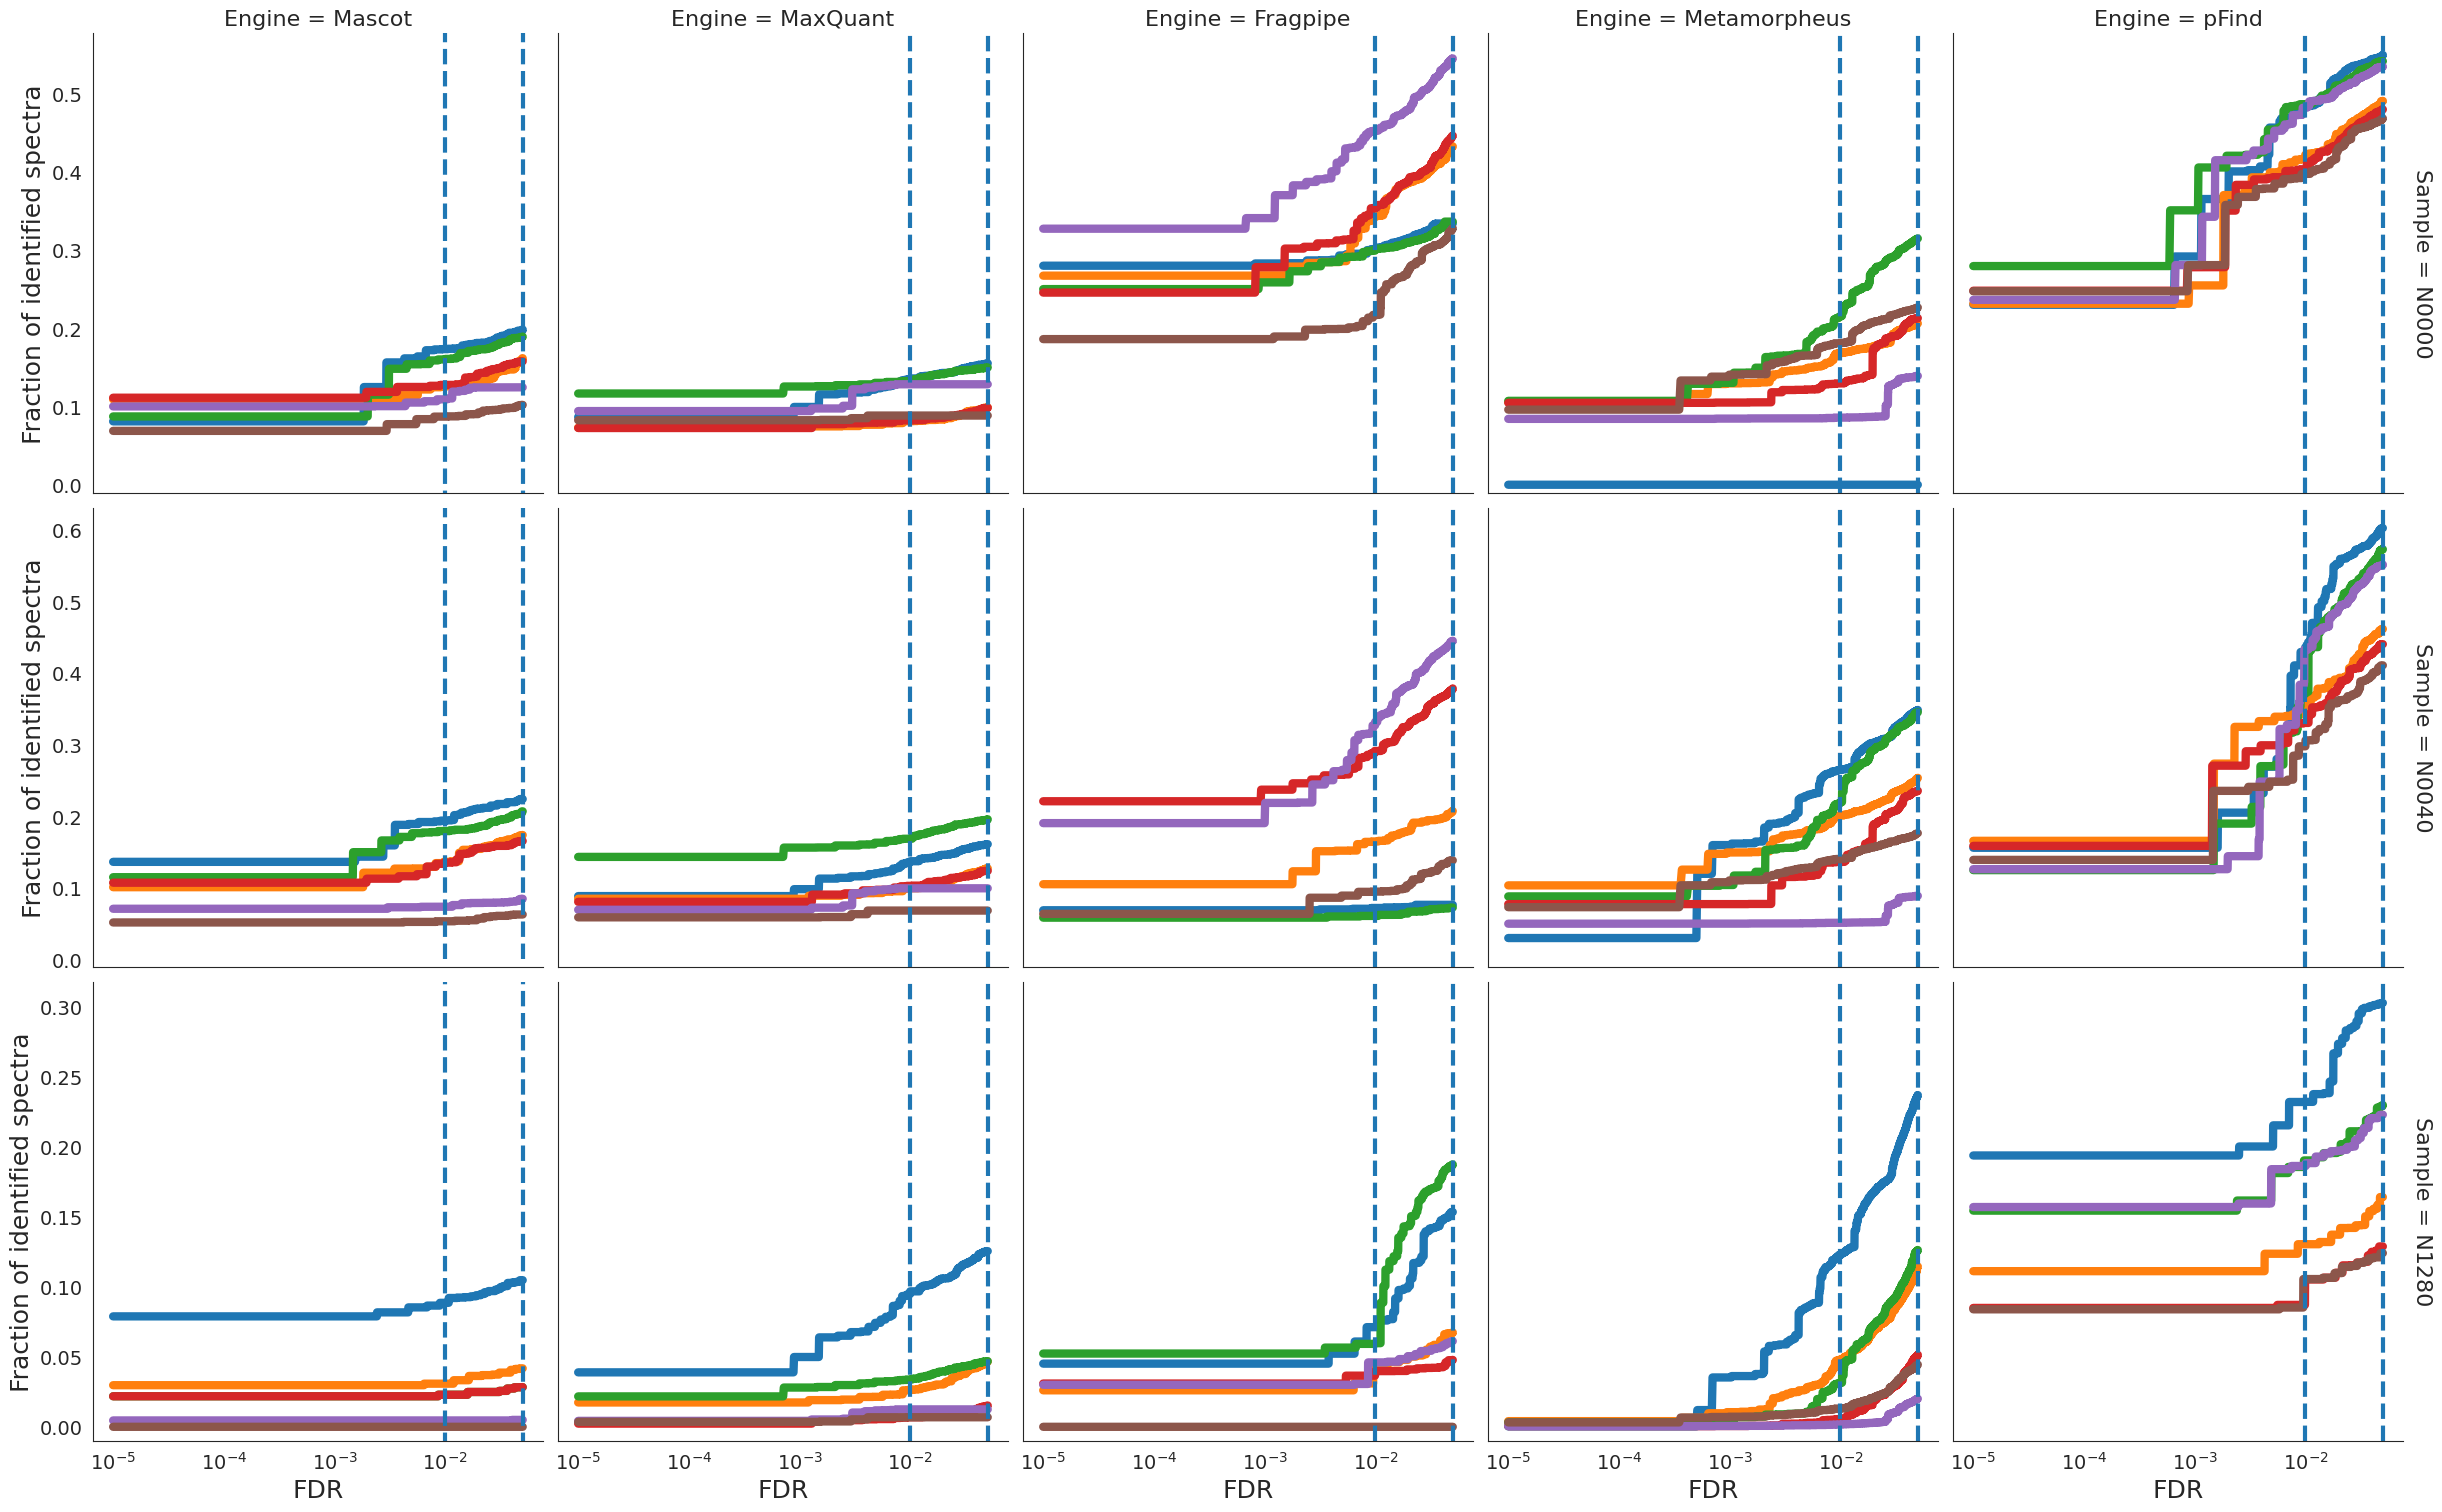

In [10]:
psms_counts_fig = plot_psms_by_fdr(psm_counts_df, n_scans=None, rel=True, col_order=software)
psms_counts_fig

In [12]:
psms_counts_fig.savefig(os.path.join(project, 'analysis_results', 'psms_counts.png'), dpi=400)
psms_counts_fig.savefig(os.path.join(project, 'analysis_results', 'psms_counts.svg'), dpi=400, format='svg')

# Venn Diagrams on peptides

In [ ]:
a = ['fp_t_db1', 'fp_st_db1', 'fp_ns_db1']
(psm_data_df[['Run_id', 'Run settings']]
    .groupby('Run_id', as_index=False).first()
    .query('Run_id in @a')
    .set_index('Run_id').loc[a,'Run settings'].values)

[None]

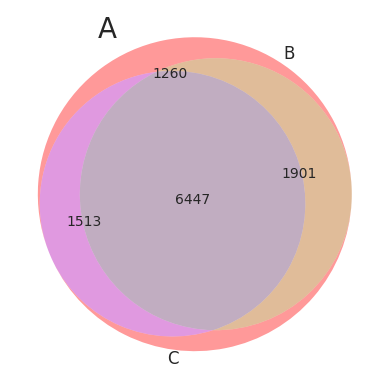

In [8]:
v = venn3(
    [
        set(psm_data_df.query('Run_id == "mq_ns_db1"').Scan_idx),
        set(psm_data_df.query('Run_id == "fp_ns_db1"').Scan_idx),
        set(psm_data_df.query('Run_id == "pf_ns_db1"').Scan_idx)
    ], set_labels = ['A', 'B', 'C']
)

v.get_label_by_id('A').set(fontsize=20)

In [14]:
def get_run_labels(run_ids, benchmark_table):
    run_labels = (
        benchmark_table[['Run_id', 'Run settings']]
        .query('Run_id in @run_ids')
        .set_index('Run_id').loc[run_ids,'Run settings'].values)
    return run_labels

def plot_venn_pepts(data, samples, runs, circle_labels=None, venn_labels=None, venn_by='samples'):
    if venn_by == 'samples':
        outer = 'Sample'
        inner = 'Run_id'
        venn_var = samples
        circle_var = runs
    elif venn_by == 'runs':
        outer = 'Run_id'
        inner = 'Sample'
        venn_var = runs
        circle_var = samples
    else:
        raise ValueError(f"venn_by value {venn_by} not valid")
    if circle_labels is None:
        circle_labels = circle_var
    if venn_labels is None:
        venn_labels = venn_var

    figure, axes = plt.subplots(1, len(venn_var), figsize=(15, 7))
    for i, v in enumerate(venn_var):
        set_list = []
        for c in circle_var:
            set_list.append(set(data.query(f'{outer} == @v and {inner} == @c').Seq))
        v = venn3(set_list, set_labels=circle_labels, ax = axes[i])
        axes[i].text(0.2, 1.1, f'{outer}: {venn_labels[i]}', transform=axes[i].transAxes,
                     size=12, weight='demi')
        for c in ('A', 'B', 'C'):
            v.get_label_by_id(c).set(fontsize=12)
    figure.tight_layout()
    return figure


/home/ismael/anaconda3/envs/msms/lib/python3.11/site-packages/matplotlib_venn/_venn3.py:61: UserWarning: Circle C has zero area
  warnings.warn("Circle C has zero area")


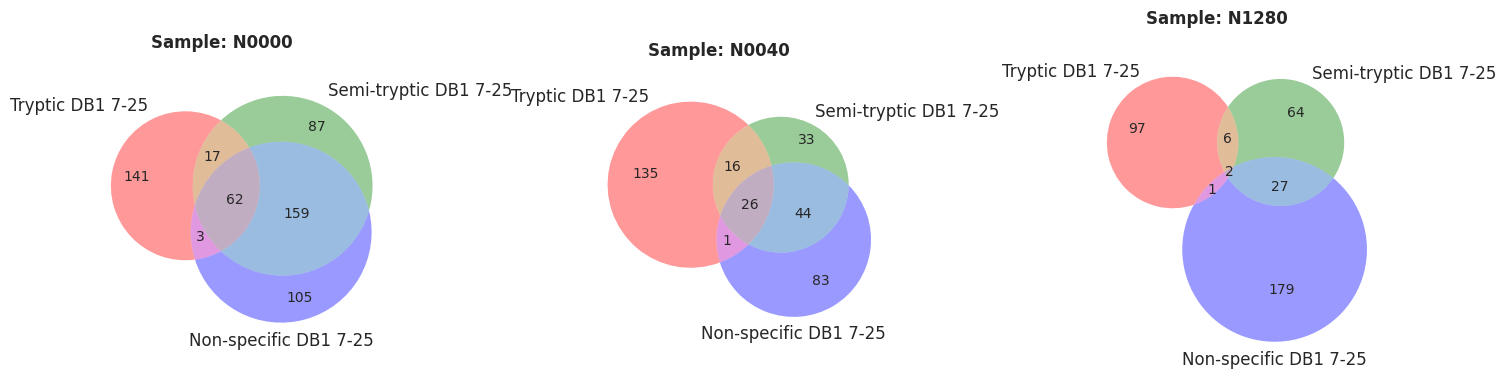

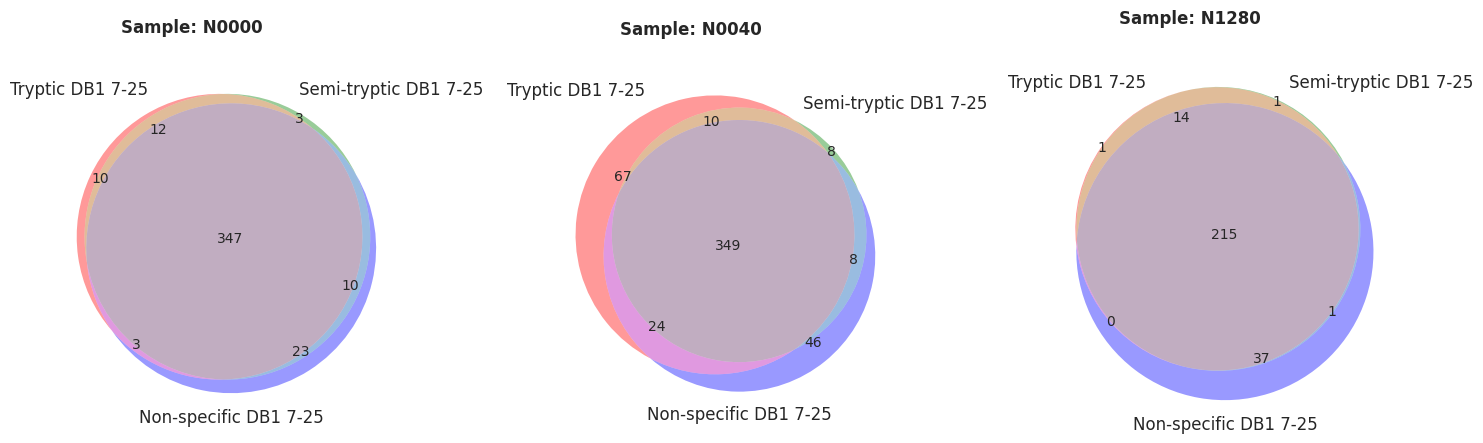

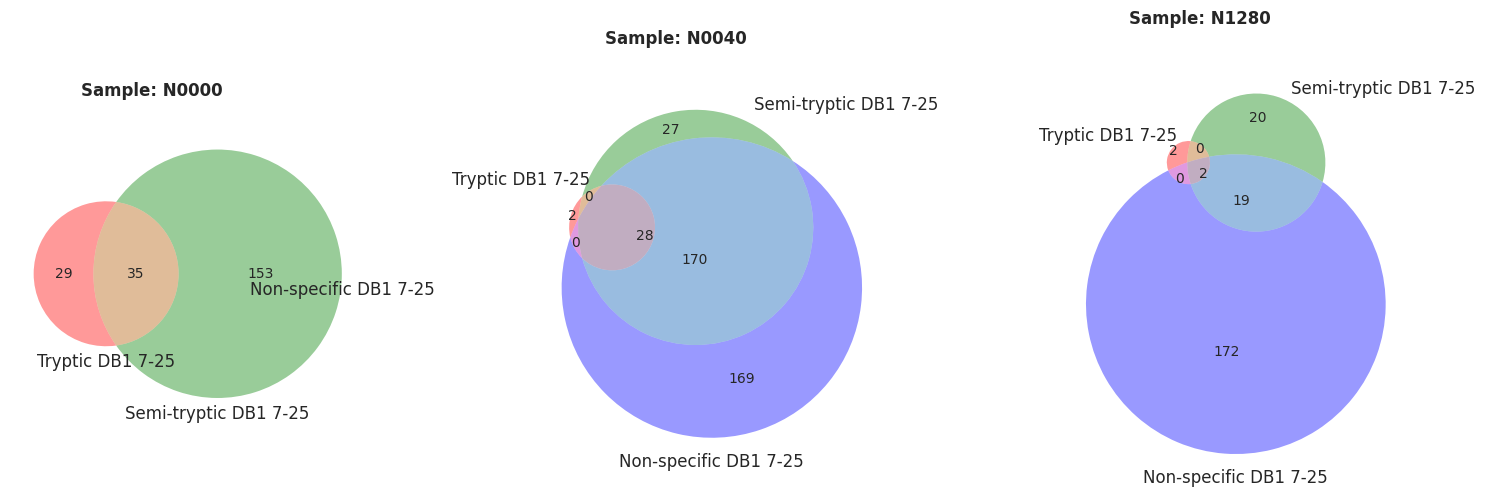

In [15]:

fp_venn_runs = ['fp_t_db1', 'fp_st_db1', 'fp_ns_db1']
fp_venn = plot_venn_pepts(
    psm_data_df.query('q <= 0.01'),
    ['N0000', 'N0040', 'N1280'], fp_venn_runs,
    circle_labels = get_run_labels(fp_venn_runs, benchmark_table),
    venn_by='samples'
)
fp_venn.savefig(os.path.join(project, 'analysis_results', 'fragpipe_venn.png'), format='png', dpi=400)
fp_venn.savefig(os.path.join(project, 'analysis_results', 'fragpipe_venn.svg'), format='svg', dpi=400)


pfind_venn_runs = ['pf_t_db1', 'pf_st_db1', 'pf_ns_db1']
pfind_venn = plot_venn_pepts(
    psm_data_df.query('q <= 0.01'),
    ['N0000', 'N0040', 'N1280'], pfind_venn_runs,
    circle_labels = get_run_labels(pfind_venn_runs, benchmark_table),
    venn_by='samples'
)
pfind_venn.savefig(os.path.join(project, 'analysis_results', 'pfind_venn.png'), format='png', dpi=400)
pfind_venn.savefig(os.path.join(project, 'analysis_results', 'pfind_venn.svg'), format='svg', dpi=400)


mm_venn_runs = ['mm_t_db1', 'mm_st_db1', 'mm_ns_db1']
mm_venn = plot_venn_pepts(
    psm_data_df.query('q <= 0.01'),
    ['N0000', 'N0040', 'N1280'], mm_venn_runs,
    circle_labels = get_run_labels(mm_venn_runs, benchmark_table),
    venn_by='samples'
)
mm_venn.savefig(os.path.join(project, 'analysis_results', 'mm_venn.png'), format='png', dpi=400)
mm_venn.savefig(os.path.join(project, 'analysis_results', 'mm_venn.svg'), format='svg', dpi=400)
